# Deterministic Test

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = []

# Plots
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
scatterShowLines = False
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95]

# Residuals to compute
residualNames = [
    ('coveredUsersPercent', 'percentage of covered users (residuals)'),
    ('collisions', 'total number of collisions (residuals)'),
    ('msgsPerSlot', 'total number of messages sent (residuals)'),
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for i, d in vecPerfIndexes:
    residualNames.append((i, d + ' (residuals)'))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

# Scatter plot whitelists
configsShown = range(0, configsCount)
repetitionsShown = range(0, repetitionsCount)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 100


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Compute residuals (should all be zero)

In [8]:
# coverage
scalars_wide['coveredUsersPercentMean'] = scalars_wide['coveredUsersPercent'].mean()
scalars_wide['coveredUsersPercentResidual'] = scalars_wide['coveredUsersPercent'] - scalars_wide['coveredUsersPercentMean']

# collisions
scalars_wide['collisionsMean'] = scalars_wide['Floorplan.collisions:sum'].mean()
scalars_wide['collisionsResidual'] = scalars_wide['Floorplan.collisions:sum'] - scalars_wide['collisionsMean']

# msgsPerSlot
scalars_wide['msgsPerSlotMean'] = scalars_wide['Floorplan.msgsPerSlot:sum'].mean()
scalars_wide['msgsPerSlotResidual'] = scalars_wide['Floorplan.msgsPerSlot:sum'] - scalars_wide['msgsPerSlotMean']

# vectors
skipped = []
for vecPerfIndex, _ in vecPerfIndexes:
    mean = scalars_wide[vecPerfIndex].mean()
    if math.isinf(mean):
        skipped.append(vecPerfIndex)
        continue
    scalars_wide[vecPerfIndex + 'Mean'] = mean
    scalars_wide[vecPerfIndex + 'Residual'] = scalars_wide[vecPerfIndex] - scalars_wide[vecPerfIndex + 'Mean']
for i, d in vecPerfIndexes:
    if i not in skipped:
        continue
    print(i + ' skipped due to infinite values in observations')
    residualNames.remove((i, d + ' (residuals)'))

## Plot variance (should be zero)

qname,config
run,
Deterministic-0-20210222-16:50:18-30960,0.0


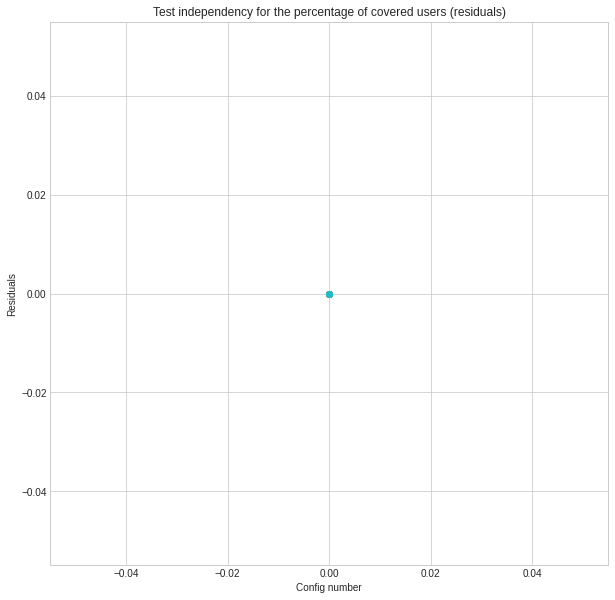

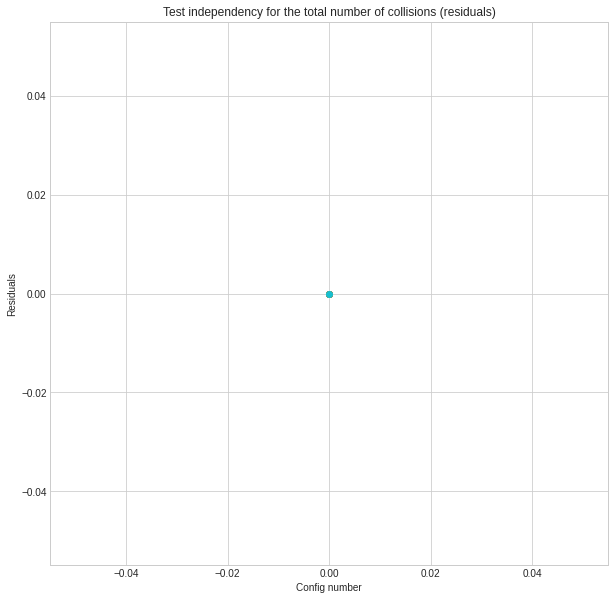

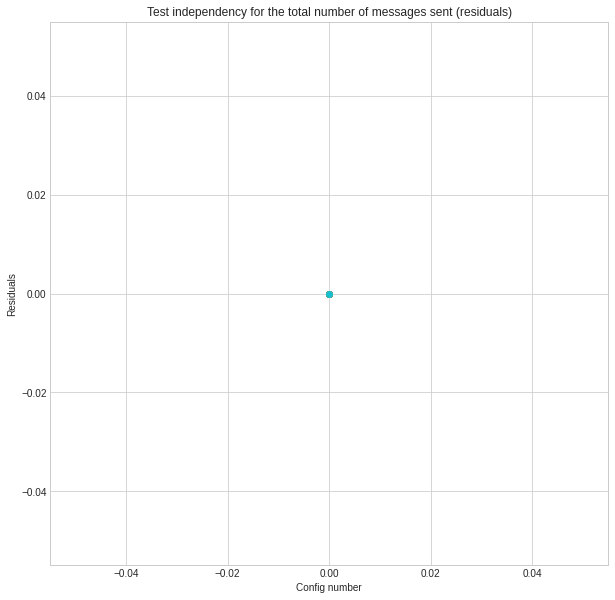

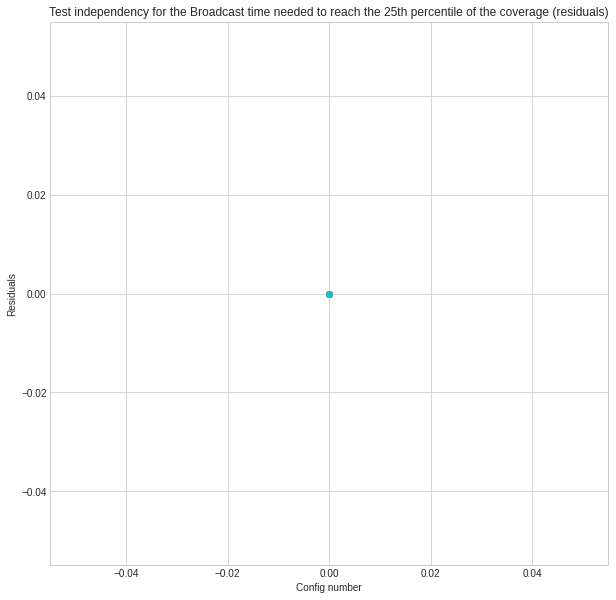

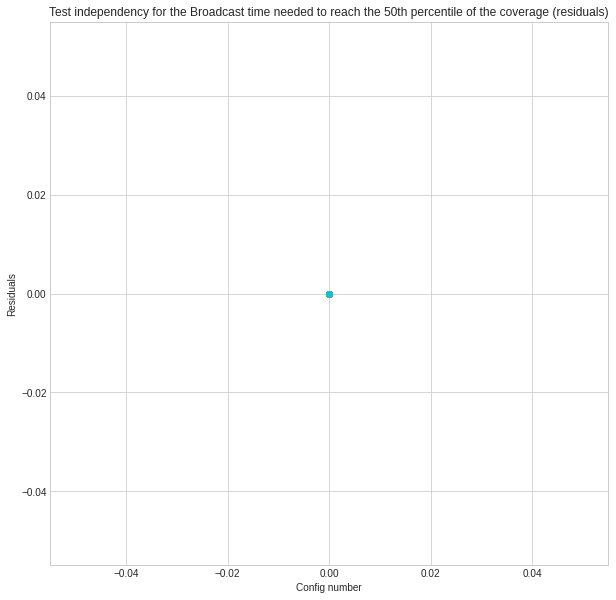

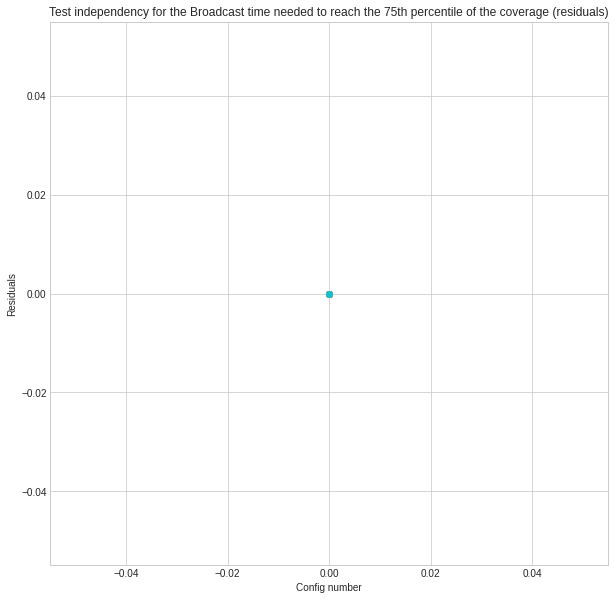

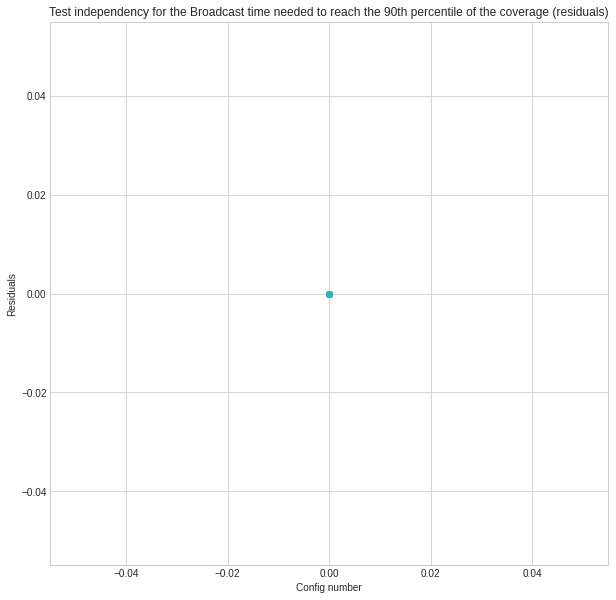

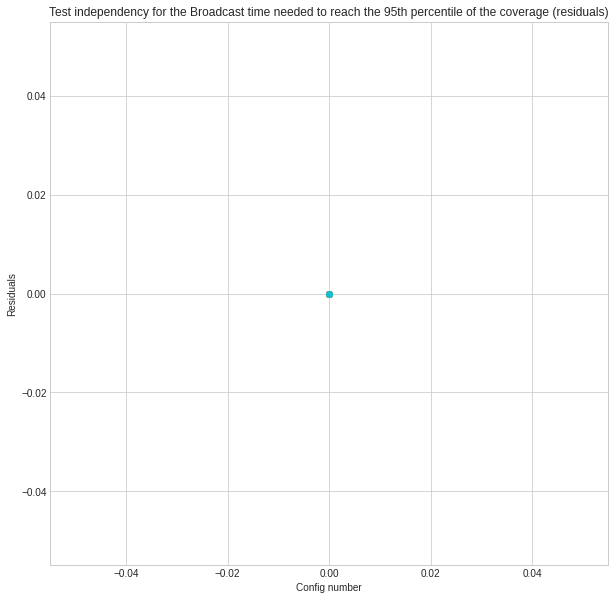

In [9]:
display(scalars_wide.loc[(scalars_wide.repetition == 0) & (scalars_wide.config.isin(configsShown))][['config', *factors]])
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append([config] * len(repetitionsShown))
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test independency for the " + vardesc)
    plt.xlabel("Config number")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-variance.png')
    plt.show()

All residuals are zero. Test passed.

### Rerun this notebook

To rerun this notebook, you can:
- just rerun the simulations with the corresponding configuration: `./simulate.sh -s DeterministicTest -c Deterministic`
- download our datasets from `https://drive.google.com/file/d/1ZFRV2DecoTvax9lngEsuPPw8Cz1DXvLc/view?usp=sharing` (login with UNIPI institutional account)